### Imports

In [1]:
from text_adventure_games import (
    games, parsing, actions, things, blocks, viz
)

## Locations

In [2]:
front_desk = things.Location(
    "Front Desk",
    "You're standing behind the front desk. There is a customer standing there waiting for you."
)
indoor_playground = things.Location(
    "Indoor Playground",
    "You're standing inside the indoor playground. There are multiple play structures for the dogs to use."
)
backyard = things.Location(
    "Backyard",
    "You're standing in the backyard. There is an open grass area for the dogs to roam, and a box of toys near you."
)
hallway = things.Location(
    "Hallway",
    "You are walking in the hallway."
)
storage_closet = things.Location(
    "Storage Closet",
    "You've walked into the storage closet. There are a lot of different boxes."
)
wash_station = things.Location(
    "Wash Station",
    "You're at the dog wash station. There is machinery to help wash the dogs."
)

# Map of Locations
front_desk.add_connection("south", indoor_playground)
indoor_playground.add_connection("out", backyard)
indoor_playground.add_connection("east", hallway)
indoor_playground.add_connection("west", wash_station)
storage_closet.add_connection("west", hallway)


## Visualizer

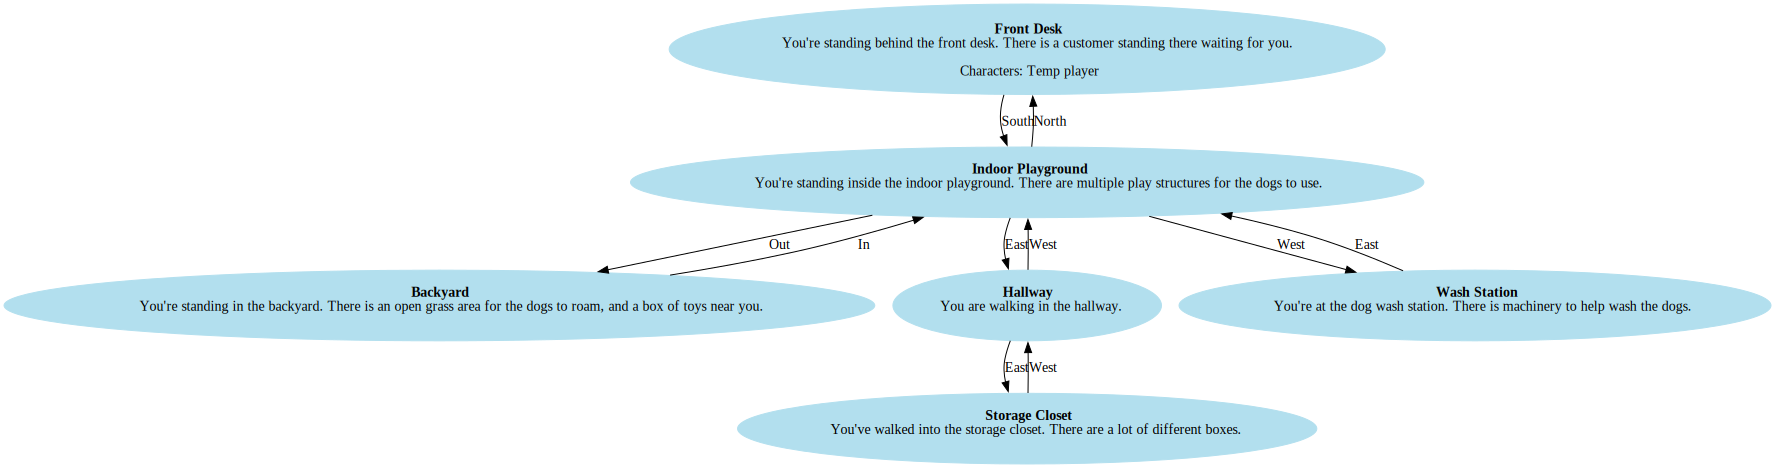

In [3]:
tempgame = games.Game(front_desk, things.Character(name="Temp Player", description="", persona=""))

from text_adventure_games.viz import Visualizer
viz = Visualizer(tempgame)
graph = viz.visualize()
graph

# Items

### Gettable Items

In [4]:
tennis_ball = things.Item(
    "ball",
    "a tennis ball",
    "A GREEN TENNIS BALL.",
)
tennis_ball.add_command_hint("throw ball")
backyard.add_item(tennis_ball)

moose_toy = things.Item(
    "moose",
    "a moose stuffed animal",
    "A STUFFED ANIMAL OF A MOOSE. A CERTAIN DOG LIKES TO PLAY TUG-OF-WAR WITH THIS MOOSE..."
)
moose_toy.add_command_hint("play tug-of-war with...")
storage_closet.add_item(moose_toy)

bone = things.Item(
    "bone",
    "a doggy bone",
    "A DOG BONE."
)
bone.set_property("is_food", True)
bone.set_property(
    "taste", "good enough to keep him distracted!"
)
wash_station.add_item(bone)


### Scenery Items

In [5]:
toy_box = things.Item(
    "toy box",
    "a box of toys",
    "A BOX CONTAINING A MULTITUDE OF TOYS."
)
toy_box.set_property("gettable", False)
toy_box.set_property("has_moose", True)
backyard.add_item(toy_box)

door = things.Item(
    "door",
    "a closet door",
    "THE CLOSET DOOR IS SECURELY LOCKED."
)
door.set_property("gettable", False)
door.set_property("is_locked", True)
door.add_command_hint("unlock door")
hallway.add_item(door)

owner = things.Item(
    "owner",
    "Popeye's owner",
    "THE OWNER OF POPEYE, WAITING TO PICK HIM UP"
)
owner.set_property("gettable", False)
owner.set_property("has_popeye", False)
owner.add_command_hint("hand over popeye")
front_desk.add_item(owner)

# Characters

In [6]:
# Player
player = things.Character(
    name="The player",
    description="You are the owner of the doggy daycare",
    persona="I am on an adventure...to take care of dogs.",
)
player.set_property("gave_popeye", False)
player.set_property("caused_trouble", False)

# Dogs
bear = things.Character(
    name="Bear",
    description="Bear, a brown laborador retriever. Brother to Bella. Very lazy and loves to bathe in the sun.",
    persona="Woof!",
)
bear.set_property("is_sunbathing", True)
backyard.add_character(bear)
key = things.Item("key", "a brass key", "THIS LOOKS USEFUL")
bear.add_to_inventory(key)

bella = things.Character(
    name="Bella",
    description="Bella, a black laborador retriever. Sister to Bear. Very friendly to people and her brother, but not to other dogs.",
    persona="Arf!",
)
bella.set_property("wants_to_fetch", False)
backyard.add_character(bella)

popeye = things.Character(
    name="Popeye",
    description="Popeye, a pitbull. Popeye is deaf and loves to play with toys.",
    persona="Ruff!",
)
popeye.set_property("will_play", True)
popeye.set_property("is_asleep", True)
popeye.set_property("has_moose", False)
indoor_playground.add_character(popeye)

yogi = things.Character(
    name="Yogi",
    description="Yogi, a pitbull. Yogi is very tiny and a bit of a troublemaker.",
    persona="Yip!",
)
yogi.set_property("is_hungry", True)
front_desk.add_character(yogi)


## Actions

In [7]:
class Unlock_Door(actions.Action):
    ACTION_NAME = "unlock door"
    ACTION_DESCRIPTION = "Unlock a door with a key"
    ACTION_ALIASES = []
    
    def __init__(self, game, command):
        super().__init__(game)
        # TODO - your code here
        self.character = self.parser.get_character(command)
        self.key = self.parser.match_item(
            "key", self.parser.get_items_in_scope(self.character)
        )
        self.door = self.parser.match_item(
            "door", self.parser.get_items_in_scope(self.character)
        )

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * There must be a door
        * The character must be at the same location as the door
        * The door must be locked
        * The character must have the key in their inventory
        """
        # TODO - your code here
        if not self.was_matched(self.door, "There's no door here."):
            return False
        if not self.door.location.here(self.character):
            return False
        if not self.door.get_property("is_locked"):
            description = "The door is already unlocked."
            self.game.parser.fail(description)
            return False
        if not self.key:
            description = "This door requires a key."
            self.game.parser.fail(description)
            return False
        if not self.character.is_in_inventory(self.key):
            description = "This door requires a key to be unlocked."
            self.game.parser.fail(description)
            return False
        return True

    def apply_effects(self):
        """
        Effects:
        * Unlocks the door
        """
        # TODO - your code here
        self.door.set_property("is_locked", False)
        description = "{name} uses the {item} to open the door. The door is now open.".format(
            name=self.character.name, item=self.key.name
        )
        self.parser.ok(description)

In [8]:
class Throw_Ball(actions.Action):
    ACTION_NAME = "throw ball"
    ACTION_DESCRIPTION = "Throw the tennis ball around."
    ACTION_ALIASES = ["play fetch"]

    def __init__(self, game, command):
        super().__init__(game)
        self.character: things.Character = self.parser.get_character(command)
        self.ball = self.parser.match_item("ball", self.character.inventory)
        self.toybox = self.parser.match_item(
            "toy box", self.parser.get_items_in_scope(self.character)
        )
        self.bear: things.Character = self.parser.get_character("bear")
        self.bella: things.Character = self.parser.get_character("bella")

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * Character must be outside in the backyard (to have the correct effect)
        * Bear AND Bella must be in the same location as the character
        * Bear must be currently sunbathing 
        * Character must have the tennis ball in their inventory
        """
        if not self.ball:
            description = "There is no ball to throw."
            self.game.parser.fail(description)
            return False
        if not self.character.is_in_inventory(self.ball):
            description = "There is no ball in your inventory to throw."
            self.game.parser.fail(description)
            return False
        if not self.toybox.location.here(self.character):
            description = "You throw the ball, but no one seems to want to play."
            self.game.parser.fail(description)
            return False
        if not self.bella.location == self.character.location:
            description = "You throw the ball, but no one seems to want to play."
            self.game.parser.fail(description)
            return False
        if not self.bear.location == self.bella.location:
            description = "You throw the ball, but no one seems to want to play."
            self.game.parser.fail(description)
            return False
        if not self.bear.get_property("is_sunbathing"):
            description = "You throw the ball, but no one seems to want to play."
            self.game.parser.fail(description)
            return False
        return True

    def apply_effects(self):
        self.bear.set_property("is_sunbathing", False)
        description = "You throw the ball, and Bella chases after it. Bear notices that, and gets up to try and take the ball away from Bella. The two are occupied now.".format(
            name=self.character.name
        )
        self.parser.ok(description)

        # Drop all items in Bear's inventory
        items = list(self.bear.inventory.keys())
        for item_name in items:
            item = self.bear.inventory[item_name]
            command = "As bear gets up, he reveals that he was laying down on a {item}".format(
                item=item_name
            )
            backyard.add_item(item)
            self.parser.ok(command)

In [9]:
class Tug_of_War(actions.Action):
    ACTION_NAME = "play tug of war"
    ACTION_DESCRIPTION = "Play tug of war with a dog"
    ACTION_ALIASES = []

    def __init__(self, game, command):
        super().__init__(game)

        command_before_word = ""
        split = command.split("play tug of war", 1)
        command_after_word = split[1]

        self.player = self.parser.get_character(command_before_word)
        self.dog = self.parser.get_character(command_after_word)
        self.moose = self.parser.match_item("moose", self.player.inventory)

    def check_preconditions(self) -> bool:
        if not self.player.location == self.dog.location:
            description = "{propositioned} is not here.".format(propositioned=self.dog.name)
            self.game.parser.fail(description)
            return False
        if not self.moose:
            description = "You need a toy to play tug of war.".format(name=self.dog.name)
            self.game.parser.fail(description)
            return False
        if not self.player.is_in_inventory(self.moose) and self.dog.get_property("will_play"):
            description = "{name} opens his eyes and looks at you, but then goes back to sleep. {name} does not want to play tug-of-war right now.".format(name=self.dog.name)
            self.game.parser.fail(description)
            return False
        if not self.dog.get_property("will_play"):
            description = "You start to play tug-of-war with {name}, but that causes the moose to rip apart. Popeye and his owner are going to be very angry with you!!!\nGAME OVER".format(
                name=self.dog.name
            )
            self.game.parser.fail(description)
            self.player.set_property("caused_trouble", True)
            return False
        if self.dog.get_property("has_moose"):
            description = "{name} does not want to play tug-of-war right now.".format(name=self.dog.name)
            self.game.parser.fail(description)
            return False
        return True
    
    def apply_effects(self):
        """
        You play tug of war and tire out Popeye; he's now ready to leave
        """
        # TODO - your code here
        self.dog.set_property("is_asleep", False)
        self.dog.set_property("has_moose", True)
        front_desk.add_character(self.dog)
        indoor_playground.remove_character(self.dog)
        description = "You tap Popeye awake and show him the moose. His ears perk up, and you play tug of war with him. He's too strong so he grabs the moose from you and runs to the front desk".format(
            name=self.player.name
        )
        self.parser.ok(description)

In [10]:
class Hand_Over(actions.Action):
    ACTION_NAME = "hand over"
    ACTION_DESCRIPTION = "Hand over Popeye to his owner."
    ACTION_ALIASES = []
    
    def __init__(self, game, command):
        super().__init__(game)
        # TODO - your code here
        command_before_word = ""
        split = command.split("hand over", 1)
        command_after_word = split[1]

        self.character: things.Character = self.parser.get_character(command_before_word)
        self.popeye: things.Character = self.parser.get_character(command_after_word)
        self.owner: things.Item = self.parser.match_item(
            "owner", self.parser.get_items_in_scope(self.character)
        )
        self.yogi: things.Character = self.parser.get_character("yogi")

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * The character must be in the front office
        * Popeye must also be in the front office
        * Yogi must be calmed down (must have the bone)
        * Popeye must be ready to hand over to owner
        """
        # TODO - your code here
        if not self.owner.location.here(self.character) and self.owner.location.here(self.popeye):
            description = "You and Popeye must both be in the front office to do that."
            self.game.parser.fail(description)
            return False
        if self.popeye.get_property("is_asleep"):
            description = "Popeye is still asleep!"
            self.game.parser.fail(description)
            return False
        if self.yogi.get_property("is_hungry"):
            description = "Yogi is distracting Popeye and needs to be calmed down before you can hand Popeye over. A bone might do the trick..."
            self.game.parser.fail(description)
            return False
        return True

    def apply_effects(self):
        """
        Popeye is handed over to his owner.
        """
        # TODO - your code here
        self.character.set_property("gave_popeye", True)
        description = "{name} handed over Popeye to his owner.".format(
            name=self.character.name
        )
        self.parser.ok(description)

## Blocks

In [11]:
class Door_Block(blocks.Block):
    """
    Blocks progress in this direction until the character unlocks the door.
    """

    def __init__(self, location: things.Location, door: things.Item):
        super().__init__("A locked door blocks your way", "The door ahead is locked.")
        # TODO - your code here
        self.location = location
        self.door = door

    def is_blocked(self) -> bool:
        # Conditions of block:
        # * The door is locked
        # TODO - your code here
        if not self.door.get_property("is_locked"):
            return False
        return True

In [12]:
door_block = Door_Block(hallway, door)

hallway.add_block("east", door_block)

# Play Game

In [13]:
class DoggyDaycare(games.Game):
    def __init__(
        self, start_at: things.Location, player: things.Character, characters=None,
        custom_actions=None
    ):
        super().__init__(start_at, player, characters=characters, custom_actions=custom_actions)

    def is_game_over(self) -> bool:
         # Something has set the game over state
        if self.game_over:
            return True
        if self.player.get_property("caused_trouble"):
            self.game_over_description = "You messed up your job. THE END"
            return True
        # Has the game has been won?
        return self.is_won()

    def is_won(self) -> bool:
        """ 
        Checks whether the game has been won. For Action Castle, the game is won
        once any character is sitting on the throne (has the property is_reigning).
        """
        for name, character in self.characters.items():
            if character.get_property("gave_popeye"):
                msg = "{name} gave Popeye to his owner. {name} has won the game!"
                self.parser.ok(msg.format(name=character.name.title()))
                return True
        return False

In [14]:
characters = [bear, bella, popeye, yogi]
custom_actions = [Unlock_Door, Hand_Over, Tug_of_War, Throw_Ball]

# The Game
game = DoggyDaycare(front_desk, player, characters=characters, custom_actions=custom_actions)

In [15]:
game.game_loop()

You're standing behind the front desk. There is a customer standing there
waiting for you.
Exits:
South to Indoor Playground

You see:
 * Popeye's owner
        hand over popeye
Characters:
 *
 * Yogi, a pitbull. Yogi is very tiny and a bit of a troublemaker.

You need a toy to play tug of war.
You're standing inside the indoor playground. There are multiple play structures
for the dogs to use.
Exits:
North to Front Desk
Out to Backyard
East to Hallway
West to Wash Station


Characters:
 * Popeye, a pitbull. Popeye is deaf and loves to play with toys.

You need a toy to play tug of war.
Indoor playground does not have an exit 'south'
You're standing in the backyard. There is an open grass area for the dogs to
roam, and a box of toys near you.
Exits:
In to Indoor Playground

You see:
 * a tennis ball
        play tug-of-war with...
        throw ball
 * a box of toys
Characters:
 * Bear, a brown laborador retriever. Brother to Bella. Very lazy and loves to
bathe in the sun.
 * Bella, a 